In [2]:
import pandas as pd
import re
import pymysql
from tqdm import tqdm
from glob import glob
import queue
import yaml

with open('../config.yml') as f:
    config = yaml.load(f)

project_dir = config['PROJECT']
project_db_dir = config['DATABASE']


con = pymysql.connect(host=config['MYSQL_HOST'], user=config['MYSQL_USER'], passwd=config['MYSQL_PASSWD'], 
                      db=config['MYSQL_DB'])

cur = con.cursor()

with open('../config.yml') as f:
    config = yaml.load(f)


In [3]:
organism_to_species = {
    'mouse': 'Mus musculus',
    'human': 'Homo sapiens',
    'rat': 'Rattus noregicus',
    'fruit fly': 'Drosophile melanogaster'
}
df_ptm = pd.DataFrame()

for file in glob(project_db_dir+'/ptm/sites/*'):
    ptm_type = file.split('/')[-1].split('_')[0]
    print(file)
    df = pd.read_csv(file, sep='\t', skiprows=3)
    df.loc[:, 'ptm_type'] = ptm_type
    
    df_ptm = pd.concat([df_ptm, df], ignore_index=True, axis=0)

df_ptm.loc[df_ptm['ORGANISM'] == 'mouse', 'ORGANISM'] = 'Mus musculus'
df_ptm.loc[df_ptm['ORGANISM'] == 'human', 'ORGANISM'] = 'Homo sapiens'
df_ptm.loc[df_ptm['ORGANISM'] == 'rat', 'ORGANISM'] = 'Rattus norvegicus'
df_ptm.loc[df_ptm['ORGANISM'] == 'fruit fly', 'ORGANISM'] = 'Drosophila melanogaster'
df_ptm = df_ptm.loc[df_ptm['ORGANISM'] == 'Homo sapiens']
df_ptm.columns = [col.lower() for col in df_ptm.columns]

/opt/current_project/db/ptm/sites/Ubiquitination_site_dataset


/home/kaplanlab/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/opt/current_project/db/ptm/sites/O-GalNAc_site_dataset
/opt/current_project/db/ptm/sites/Acetylation_site_dataset
/opt/current_project/db/ptm/sites/Methylation_site_dataset
/opt/current_project/db/ptm/sites/Sumoylation_site_dataset
/opt/current_project/db/ptm/sites/Phosphorylation_site_dataset
/opt/current_project/db/ptm/sites/O-GlcNAc_site_dataset


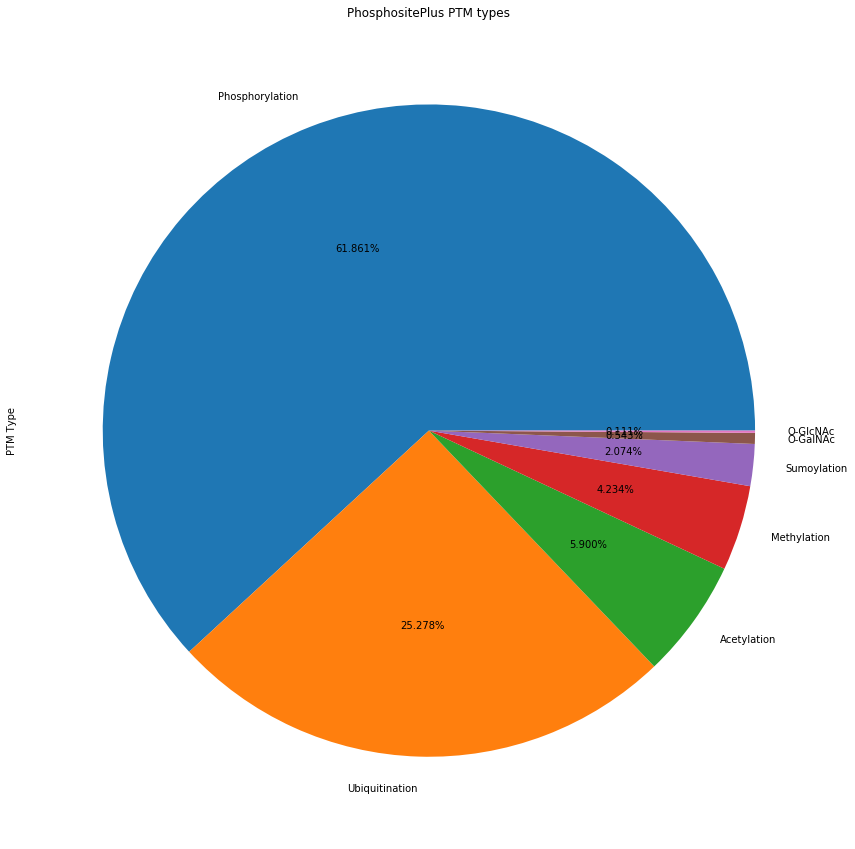

In [15]:
from matplotlib import pyplot as plt
from os import path
plt.rcParams['figure.figsize'] = [15, 15]

plt.title('PhosphositePlus PTM types')
df_ptm.ptm_type.value_counts().plot(kind='pie', autopct='%1.3f%%')
plt.ylabel('PTM Type')
plt.savefig(path.join(project_dir, 'figures', 'pie_chart_phosphositeplus.png'))
plt.show()

In [3]:
uniprot_fasta = {
    
}
uniprot_species = {
    
}
with open(project_db_dir+'/ptm/Phosphosite_PTM_seq.fasta', 'r') as f:
    lines = f.readlines()
cur_protein_id = ''
cur_species_id = ''
cur_protein = ''
for line in lines:
    if '>' not in line:
        cur_protein += line
        continue
    
    if cur_protein_id != '' and cur_species_id in organism_to_species:
        uniprot_fasta[cur_protein_id] = cur_protein.replace('\n', '')
        uniprot_species[cur_protein_id] = organism_to_species[cur_species_id]

    cur_protein_id = re.search(r'(>|)(.*?)\|(.*?)\|(.*?)\|(.*?)$', line).group(5)
    cur_species_id = re.search(r'(>|)(.*?)\|(.*?)\|(.*?)\|(.*?)$', line).group(4)

    cur_protein = ''

if cur_protein_id != '':
    if cur_species_id in organism_to_species:
        uniprot_fasta[cur_protein_id] = cur_protein.replace('\n', '')
        uniprot_species[cur_protein_id] = organism_to_species[cur_species_id]
    


In [4]:
results = []
for acc_id in tqdm(df_ptm['acc_id'].unique()):
    if acc_id not in uniprot_fasta:
        continue

    fasta = uniprot_fasta[acc_id]
    species_id = uniprot_species[acc_id]

    df = pd.read_sql("SELECT id FROM convart_gene WHERE sequence='"+fasta+"' and species_id='"+species_id+"'", con)

    if df.shape[0] != 0:
        results.append([(acc_id, row['id']) for ind, row in df.iterrows()])    

df_ptm.loc[:,'position'] = df_ptm['mod_rsd'].str.replace(r'(.)([0-9]+)-(.*?)$', r'\2')
df_ptm.to_csv(project_db_dir+'/ptm/df_ptm.csv', index=None)
# 

100%|██████████| 21308/21308 [41:16<00:00,  8.70it/s]


In [5]:
from sqlalchemy import create_engine

engine = create_engine("mysql+pymysql://{user}:{pw}@{server}/{db}"
                       .format(server=config['MYSQL_HOST'], user=config['MYSQL_USER'], pw=config['MYSQL_PASSWD'], 
                               db=config['MYSQL_DB']))
#df_ptm.to_sql('ptm', engine, if_exists='replace')

In [7]:
cur.execute('DELETE FROM convart_gene_to_db WHERE db="UNIPROT"')
con.commit()
df_results = pd.DataFrame([result[0] for result in results])
df_results.columns = ['db_id', 'convart_gene_id']
df_results.loc[:, 'db'] = 'UNIPROT'
df_results.to_sql('convart_gene_to_db', engine, if_exists='append', index=False)

In [8]:
ptms_mapping = {}

for ind, row in tqdm(df_ptm.iterrows()):
    key = row['acc_id']+','+str(row['position'])
    if key not in ptms_mapping:
        ptms_mapping[key] = []
    
    ptms_mapping[key].append(row)


387428it [00:41, 9392.81it/s] 


In [18]:
df_clinvar = pd.read_sql("""SELECT clinvar.*, cdb_uniprot.db_id AS acc_id FROM clinvar INNER JOIN convart_gene_to_db AS cdb ON 
                    cdb.db_id = clinvar.np_id INNER JOIN convart_gene_to_db AS cdb_uniprot ON 
                    cdb_uniprot.convart_gene_id = cdb.convart_gene_id AND cdb_uniprot.db = 'uniprot'
                    GROUP BY clinvar.clinvar_id""", con)


In [19]:
ptm_clinvar_rows = []


for ind, row in tqdm(df_clinvar.iterrows()):
    key = row['acc_id'] + ',' + str(row['position'])
    
    if key in ptms_mapping:
        for ptm in ptms_mapping[key]:
            ptm_clinvar_rows.append(pd.concat([row, ptm]).to_dict())
df_ptm_clinvar = pd.DataFrame(ptm_clinvar_rows)
   

281871it [00:31, 9044.92it/s] 


In [20]:
df_ptm_clinvar.to_excel(project_dir+'/results/novel_data/clinvar_ptm.xlsx', index=None)

In [21]:
df_gnomad = pd.read_sql("""SELECT gnomad.*, cdb_uniprot.db_id AS acc_id FROM gnomad INNER JOIN convart_gene_to_db AS cdb ON 
                    cdb.db_id = gnomad.canonical_transcript INNER JOIN convart_gene_to_db AS cdb_uniprot ON 
                    cdb_uniprot.convart_gene_id = cdb.convart_gene_id AND cdb_uniprot.db = 'uniprot'
                    GROUP BY gnomad.id
""", con)


In [22]:
ptm_gnomad_rows = []

for ind, row in tqdm(df_gnomad.iterrows(), miniters=10000):
    key = row['acc_id'] + ',' + str(row['position'])
    
    if key in ptms_mapping:
        for ptm in ptms_mapping[key]:
            ptm_gnomad_rows.append(pd.concat([row, ptm]).to_dict())
df_ptm_gnomad = pd.DataFrame(ptm_gnomad_rows)
df_ptm_gnomad.to_excel(project_dir+'/results/novel_data/gnomad_ptm.xlsx', index=None)

9587773it [15:35, 10252.56it/s]


In [23]:
df_cosmic = pd.read_sql("""SELECT accession_number, sample_name, fathmm_prediction, fathmm_score, id_sample, id_tumour, primary_site, primary_histology, mutation_id, mutation_cds, mutation_aa, snp, position, mutation_somatic_status, cdb_uniprot.db_id AS acc_id FROM CosmicMutantExport as cosmic
                    INNER JOIN convart_gene_to_db AS cdb ON cdb.db_id = cosmic.accession_number
                    INNER JOIN convart_gene_to_db AS cdb_uniprot ON 
                    cdb_uniprot.convart_gene_id = cdb.convart_gene_id AND cdb_uniprot.db = 'uniprot'
                    GROUP BY cosmic.cme_id
""", con)

In [24]:
ptm_cosmic_rows = []

for ind, row in tqdm(df_cosmic.iterrows(), miniters=10000):
    key = row['acc_id'] + ',' + str(row['position'])

    if key in ptms_mapping:
        for ptm in ptms_mapping[key]:
            ptm_cosmic_rows.append(pd.concat([row, ptm]).to_dict())

df_ptm_cosmic = pd.DataFrame(ptm_cosmic_rows)
df_ptm_cosmic.to_excel(project_dir+'/results/novel_data/cosmic_ptm.xlsx', index=None)

4613231it [08:11, 9384.76it/s]


In [25]:
clinical_significance_mapping = {}

significance_lists = {
    'benign': ["Benign","Benign, association","Benign/Likely benign","Benign/Likely benign, Affects","Benign/Likely benign, association",
			"Benign/Likely benign, drug response","Benign/Likely benign, drug response, risk factor","Benign/Likely benign, other","Benign/Likely benign, protective",
			"Benign/Likely benign, protective, risk factor","Benign/Likely benign, risk factor","Benign, other","Benign, risk factor","Likely benign",
			"Likely benign, drug response, other","Likely benign, other","Likely benign, risk factor"],
    'vus': ["Uncertain significance","Uncertain significance, drug response","Uncertain significance, other","Uncertain significance, risk factor"],
    'pathogenic': ["Pathogenic","Pathogenic, Affects","Pathogenic, association, protective","Pathogenic, drug response","Pathogenic/Likely pathogenic",
"Pathogenic/Likely pathogenic, drug response","Pathogenic/Likely pathogenic, other","Pathogenic/Likely pathogenic, risk factor","Pathogenic, other",
"Pathogenic, other, risk factor","Pathogenic, protective","Pathogenic, risk factor","Likely pathogenic","Likely pathogenic, association",
"Likely pathogenic, drug response","Likely pathogenic, other","Likely pathogenic, risk factor"]
}

for key, vals in significance_lists.items():
    for val in vals:
        clinical_significance_mapping[val] = key
        
df_clinvar_wo_ptm = df_clinvar.copy()
indices = []

for ind, row in tqdm(df_clinvar.iterrows()):
    key = row['acc_id'] + ',' + str(row['position'])
    
    if key in ptms_mapping:
        indices.append(ind)

df_clinvar_wo_ptm.drop(indices, inplace=True)
significance_comparison = pd.DataFrame(
    {'with_ptm': df_ptm_clinvar['clinical_significance'].apply(lambda x: None if x not in clinical_significance_mapping else 
                                                      clinical_significance_mapping[x]).value_counts()/df_ptm_clinvar.shape[0],
     'without_ptm': df_clinvar_wo_ptm['clinical_significance'].apply(lambda x: None if x not in clinical_significance_mapping else 
                                                      clinical_significance_mapping[x]).value_counts()/df_clinvar_wo_ptm.shape[0]})

significance_comparison.plot(kind='bar')

281871it [00:29, 9426.58it/s] 


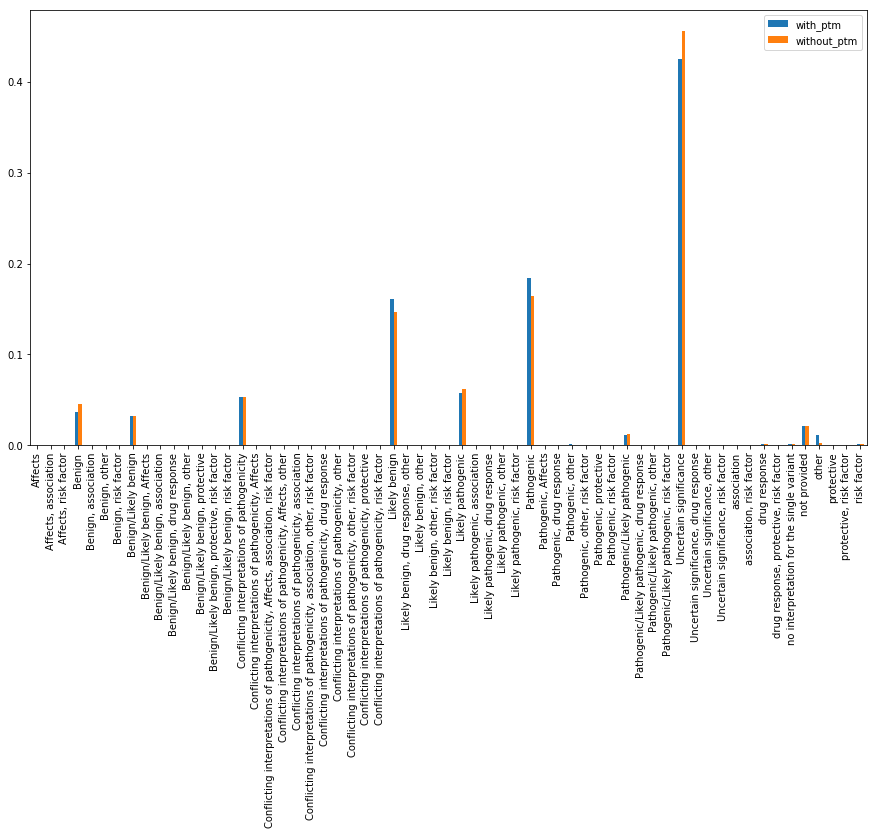

In [27]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
significance_comparison = pd.DataFrame(
    {'with_ptm': df_ptm_clinvar['clinical_significance'].value_counts()/df_ptm_clinvar.shape[0],
     'without_ptm': df_clinvar_wo_ptm['clinical_significance'].value_counts()/df_clinvar_wo_ptm.shape[0]})

significance_comparison.plot(kind='bar')